In [ ]:
!pip install -q rouge_score

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 12.1 MB/s eta 0:00:00


In [ ]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is i

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import transformers
import evaluate
from datasets import load_dataset, load_metric
from datetime import datetime, timedelta
import pytz
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
### Defining Functions for the Calculation of various scores

rouge = evaluate.load('rouge')
meteor = evaluate.load('meteor')
bertscore = evaluate.load('bertscore')
def calculate_model_rouge_scores(df):
  # count = 1
  est_start = get_current_time_est()

  def compute_rouge_scores(row):
    prediction = row['GeneratedText']
    reference = row['ReferenceText']
    rouge_scores = rouge.compute(predictions=[prediction], references=[reference])
    # count[0] += 1
    # print(f'Example {count[0]} ROUGE scored.')
    return pd.Series(rouge_scores)

  df_rouge = df.apply(compute_rouge_scores, axis=1)
  df = pd.concat([df, df_rouge], axis=1)

  calculate_duration(est_start)

  return df

def calculate_model_meteor_scores(df):
  # count = 1
  est_start = get_current_time_est()


  def compute_meteor_scores(row):
    prediction = row['GeneratedText']
    reference = row['ReferenceText']
    rouge_scores = meteor.compute(predictions=[prediction], references=[reference])
    # count[0] += 1
    # print(f'Example {count[0]} METEOR scored.')
    return pd.Series(rouge_scores)

  df_rouge = df.apply(compute_meteor_scores, axis=1)
  df = pd.concat([df, df_rouge], axis=1)

  calculate_duration(est_start)

  return df

def calculate_model_bert_scores(df):
  est_start = get_current_time_est()

  def compute_bert_score(row):
    prediction = row['GeneratedText']
    reference = row['ReferenceText']
    bert_scores = bertscore.compute(predictions=[prediction], references=[reference], lang="en")
    return pd.Series(bert_scores)

  df_bert = df.apply(compute_bert_score, axis=1)
  df = pd.concat([df, df_bert], axis=1)

  calculate_duration(est_start)

  return df


def get_current_time_est():
  est = pytz.timezone('US/Eastern')
  utc_start = datetime.now(pytz.utc)
  est_start = utc_start.astimezone(est)
  print(f'Start Time: {est_start}')
  return est_start

def calculate_duration(est_start):
  est = pytz.timezone('US/Eastern')
  utc_end = datetime.now(pytz.utc)
  est_end = utc_end.astimezone(est)
  time_difference = est_end - est_start
  seconds = time_difference.seconds
  hours = seconds // 3600
  minutes = (seconds % 3600) // 60
  seconds = seconds % 60
  formatted_difference = f"{hours:02}:{minutes:02}:{seconds:02}"

  print(f'Complete. Time Taken: {formatted_difference}')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
### Create Combined Files for Each Model if not Already created

files_bart_finetuned = glob.glob('/content/drive/MyDrive/DATASCI266/bart_ft_summaries/*.csv')

df_bart_finetuned = pd.DataFrame()
for csv_file in files_bart_finetuned:
    df = pd.read_csv(csv_file)
    df_bart_finetuned = pd.concat([df_bart_finetuned, df])

files_bart_base = glob.glob('/content/drive/MyDrive/DATASCI266/bart_base_summaries/*.csv')
df_bart_base = pd.DataFrame()
for csv_file in files_bart_base:
    df = pd.read_csv(csv_file)
    df_bart_base = pd.concat([df_bart_base, df])

files_pegasus_base = glob.glob('/content/drive/MyDrive/DATASCI266/model_baseline_files/*_index_*.csv')
df_pegasus_base = pd.DataFrame()
for csv_file in files_pegasus_base:
    df = pd.read_csv(csv_file)
    df_pegasus_base = pd.concat([df_pegasus_base, df])

files_pegasus_finetuned = glob.glob('/content/drive/MyDrive/DATASCI266/model_fine_tuned_files/*_index_*.csv')
df_pegasus_finetuned = pd.DataFrame()
for csv_file in files_pegasus_finetuned:
    df = pd.read_csv(csv_file)
    df_pegasus_finetuned = pd.concat([df_pegasus_finetuned, df])

In [ ]:
##### Paths for Each output
root_t5_path = '/content/drive/MyDrive/DATASCI266/model_t5_files/'

# t5 Baseline
path_t5_baseline_level_1_150 = root_t5_path + 't5_baseline_0_to_832_summarizephrase_Summarize:_maxlen150.csv'
path_t5_baseline_level_2_150 = root_t5_path + 't5_baseline_0_to_832_summarizephrase_Summarize this scholarly article:_maxlen150.csv'
path_t5_baseline_level_3_150 = root_t5_path + 't5_baseline_0_to_832_summarizephrase_Summarize this scholarly article for someone that wants to learn about environmental science:_maxlen150.csv'

# t5 Fine Tuning
path_t5_finetune_no_prompt_level_1_150 = root_t5_path + 't5_finetune_no_prompt_0_to_832_summarizephrase_Summarize:_maxlen150.csv'
path_t5_finetune_no_prompt_level_2_150 = root_t5_path + 't5_finetune_no_prompt_0_to_832_summarizephrase_Summarize this scholarly article:_maxlen150.csv'
path_t5_finetune_no_prompt_level_3_150 = root_t5_path + 't5_finetune_no_prompt_0_to_832_summarizephrase_Summarize this scholarly article for someone that wants to learn about environmental science:_maxlen150.csv'

##### Output paths with evaluations
root_evaluation_path = '/content/drive/MyDrive/DATASCI266/model_evaluations/'

# t5 Baseline
path_t5_baseline_level_1_150_evaluation = root_evaluation_path + 't5_baseline_level_1_150_evaluation.csv'
path_t5_baseline_level_2_150_evaluation = root_evaluation_path + 't5_baseline_level_2_150_evaluation.csv'
path_t5_baseline_level_3_150_evaluation = root_evaluation_path + 't5_baseline_level_3_150_evaluation.csv'

# t5 Fine Tuning
path_t5_finetune_no_prompt_level_1_150_evaluation = root_evaluation_path + 't5_finetune_no_prompt_level_1_150.csv'
path_t5_finetune_no_prompt_level_2_150_evaluation = root_evaluation_path + 't5_finetune_no_prompt_level_2_150.csv'
path_t5_finetune_no_prompt_level_3_150_evaluation = root_evaluation_path + 't5_finetune_no_prompt_level_3_150.csv'

In [ ]:
### Read in Dataframes

# t5 Baseline
df_t5_baseline_level_1_150 = pd.read_csv(path_t5_baseline_level_1_150)
df_t5_baseline_level_1_150['GeneratedText'] = df_t5_baseline_level_1_150['GeneratedText'].str.replace(r"^\[\"|\"\]$|^\['|'\]$", "", regex=True)

df_t5_baseline_level_2_150 = pd.read_csv(path_t5_baseline_level_2_150)
df_t5_baseline_level_2_150['GeneratedText'] = df_t5_baseline_level_2_150['GeneratedText'].str.replace(r"^\[\"|\"\]$|^\['|'\]$", "", regex=True)

df_t5_baseline_level_3_150 = pd.read_csv(path_t5_baseline_level_3_150)
df_t5_baseline_level_3_150['GeneratedText'] = df_t5_baseline_level_3_150['GeneratedText'].str.replace(r"^\[\"|\"\]$|^\['|'\]$", "", regex=True)

# t5 Fine Tuning
df_t5_finetune_no_prompt_level_1_150 = pd.read_csv(path_t5_finetune_no_prompt_level_1_150)
df_t5_finetune_no_prompt_level_1_150['GeneratedText'] = df_t5_finetune_no_prompt_level_1_150['GeneratedText'].str.replace(r"^\[\"|\"\]$|^\['|'\]$", "", regex=True)

df_t5_finetune_no_prompt_level_2_150 = pd.read_csv(path_t5_finetune_no_prompt_level_2_150)
df_t5_finetune_no_prompt_level_2_150['GeneratedText'] = df_t5_finetune_no_prompt_level_2_150['GeneratedText'].str.replace(r"^\[\"|\"\]$|^\['|'\]$", "", regex=True)

df_t5_finetune_no_prompt_level_3_150 = pd.read_csv(path_t5_finetune_no_prompt_level_3_150)
df_t5_finetune_no_prompt_level_3_150['GeneratedText'] = df_t5_finetune_no_prompt_level_3_150['GeneratedText'].str.replace(r"^\[\"|\"\]$|^\['|'\]$", "", regex=True)

In [ ]:
# Evaluate Models
### Ensure list indices are aligned with dataframe:file name to enumerate properly

lst_df = [df_t5_baseline_level_1_150
          , df_t5_baseline_level_2_150
          , df_t5_baseline_level_3_150
          , df_t5_finetune_no_prompt_level_1_150
          , df_t5_finetune_no_prompt_level_2_150
          , df_t5_finetune_no_prompt_level_3_150
          , df_bart_base
          , df_bart_finetuned
          , df_pegasus_base
          , df_pegasus_finetuned
          ]
lst_file_name = ['t5_baseline_level_1_150'
          , 't5_baseline_level_2_150'
          , 't5_baseline_level_3_150'
          , 't5_finetune_no_prompt_level_1_150'
          , 't5_finetune_no_prompt_level_2_150'
          , 't5_finetune_no_prompt_level_3_150'
          , 'bart_baseline'
          , 'bart_finetune'
          , 'pegasus_baseline'
          , 'pegasus_finetune'
          ]

for i , (df, file_name) in enumerate(zip(lst_df, lst_file_name)):
  print('-------------------')
  print(f'Scoring {file_name}')
  print('-------------------')
  print('Beginning BERT Scoring')
  df_bert = calculate_model_bert_scores(df)
  print('-------------------')
  print('Beginning ROUGE Scoring')
  df_rouge_bert = calculate_model_rouge_scores(df_bert)
  print('-------------------')
  print('Beginning METEOR Scoring')
  df_meteor_rouge_bert = calculate_model_meteor_scores(df_rouge_bert)

  output_path = root_evaluation_path + file_name + '.csv'
  df_meteor_rouge_bert.to_csv(output_path, index=False)
  print(f'File written to {output_path}.')

-------------------
Scoring t5_baseline_level_1_150
-------------------
Beginning BERT Scoring
Start Time: 2024-08-02 15:20:51.785814-04:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Complete. Time Taken: 00:00:54
-------------------
Beginning ROUGE Scoring
Start Time: 2024-08-02 15:21:46.393598-04:00
Complete. Time Taken: 00:02:19
-------------------
Beginning METEOR Scoring
Start Time: 2024-08-02 15:24:06.305658-04:00
Complete. Time Taken: 00:00:13
File written to /content/drive/MyDrive/DATASCI266/model_evaluations/t5_baseline_level_1_150.csv.
-------------------
Scoring t5_baseline_level_2_150
-------------------
Beginning BERT Scoring
Start Time: 2024-08-02 15:24:21.051011-04:00
Complete. Time Taken: 00:00:40
-------------------
Beginning ROUGE Scoring
Start Time: 2024-08-02 15:25:01.650444-04:00
Complete. Time Taken: 00:02:19
-------------------
Beginning METEOR Scoring
Start Time: 2024-08-02 15:27:21.098813-04:00
Complete. Time Taken: 00:00:11
File written to /content/drive/MyDrive/DATASCI266/model_evaluations/t5_baseline_level_2_150.csv.
-------------------
Scoring t5_baseline_level_3_150
-------------------
Beginning BERT Scoring
Start Time: 2024-08-02 15:2

### SUMMARY STATISTICS AND PLOTS

In [ ]:
df = pd.DataFrame()

for root, dirs, files in os.walk(root_evaluation_path):
  dirs.clear() # do not go down subfolder (e.g. ARCHIVE)
  for file in files:
    if file.endswith('.csv'):
      file_path = os.path.join(root, file)
      model_name = os.path.splitext(file)[0]
      df_model = pd.read_csv(file_path)
      df_model['precision'] = df_model['precision'].str.strip('[]').astype(float)
      df_model['recall'] = df_model['recall'].str.strip('[]').astype(float)
      df_model['f1'] = df_model['f1'].str.strip('[]').astype(float)
      df_model = df_model.select_dtypes(include=['float64'])
      df_model = df_model.mean().to_frame().T
      df_model['ModelName'] = model_name
      df = pd.concat([df, df_model], axis = 0)

df.reset_index(drop=True).head(20)

,precision,recall,f1,rouge1,rouge2,rougeL,rougeLsum,meteor,ModelName
0,0.844748,0.803063,0.822927,0.197573,0.047093,0.132328,0.132328,0.093533,t5_baseline_level_1_150
1,0.844944,0.804371,0.823712,0.200274,0.049058,0.131815,0.131815,0.097350,t5_baseline_level_2_150
2,0.847068,0.803819,0.824513,0.206709,0.048861,0.135043,0.135043,0.098910,t5_baseline_level_3_150
3,0.850295,0.820457,0.834868,0.278465,0.073214,0.166854,0.166854,0.149217,t5_finetune_no_prompt_level_1_150
4,0.850908,0.820199,0.835034,0.280365,0.074281,0.168284,0.168284,0.148704,t5_finetune_no_prompt_level_2_150
5,0.848938,0.819469,0.833721,0.277832,0.071628,0.165061,0.165061,0.149149,t5_finetune_no_prompt_level_3_150
6,0.860174,0.807270,0.832593,0.172510,0.045961,0.114340,0.114340,0.084427,bart_baseline
7,0.850311,0.818923,0.834067,0.282550,0.064702,0.161811,0.161811,0.149373,bart_finetune
8,0.832137,0.803533,0.817340,0.203752,0.041504,0.127752,0.127752,0.099223,pegasus_baseline
9,0.848333,0.819192,0.833286,0.283817,0.069719,0.164813,0.164813,0.154508,pegasus_finetune


In [ ]:
# Filtering each dataframe for a strong score

summary_value = "Strong earthquakes can cause buildings to collapse, fires, and jammed doors and elevators"

df = pd.DataFrame()

for root, dirs, files in os.walk(root_evaluation_path):
  dirs.clear() # do not go down subfolder (e.g. ARCHIVE)
  for file in files:
    if file.endswith('.csv'):
      file_path = os.path.join(root, file)
      model_name = os.path.splitext(file)[0]
      df_model = pd.read_csv(file_path)
      df_model['precision'] = df_model['precision'].str.strip('[]').astype(float)
      df_model['recall'] = df_model['recall'].str.strip('[]').astype(float)
      df_model['f1'] = df_model['f1'].str.strip('[]').astype(float)
      df_model = df_model[df_model['ReferenceText'].str.contains(summary_value)]
      df_model = df_model.select_dtypes(include=['float64'])
      df_model = df_model.mean().to_frame().T
      df_model['ModelName'] = model_name
      df = pd.concat([df, df_model], axis = 0)

df.head(10)

,precision,recall,f1,rouge1,rouge2,rougeL,rougeLsum,meteor,ModelName
0,0.841502,0.802773,0.821681,0.167300,0.015326,0.106464,0.106464,0.096789,t5_baseline_level_1_150
0,0.872282,0.844936,0.858391,0.332180,0.118467,0.221453,0.221453,0.179822,t5_baseline_level_2_150
0,0.889438,0.851727,0.870174,0.336842,0.113074,0.224561,0.224561,0.173886,t5_baseline_level_3_150
0,0.883521,0.850295,0.866590,0.354037,0.106250,0.186335,0.186335,0.218677,t5_finetune_no_prompt_level_1_150
0,0.877911,0.839398,0.858223,0.428571,0.143791,0.220779,0.220779,0.232560,t5_finetune_no_prompt_level_2_150
0,0.877700,0.829109,0.852713,0.350000,0.093525,0.192857,0.192857,0.154311,t5_finetune_no_prompt_level_3_150
0,0.836114,0.802146,0.818778,0.120482,0.008097,0.088353,0.088353,0.059581,bart_baseline
0,0.873583,0.848139,0.860673,0.386503,0.111111,0.190184,0.190184,0.233760,bart_finetune
0,0.833636,0.810176,0.821739,0.177122,0.022305,0.125461,0.125461,0.084586,pegasus_baseline
0,0.823797,0.820760,0.822276,0.258462,0.030960,0.160000,0.160000,0.134274,pegasus_finetune


In [ ]:
# Filtering for an example where a low ROUGE Score, but effective summary

summary_value = "Strong earthquakes can cause buildings to collapse, fires, and jammed doors and elevators"

df = pd.DataFrame()

for root, dirs, files in os.walk(root_evaluation_path):
  dirs.clear() # do not go down subfolder (e.g. ARCHIVE)
  for file in files:
    if file.endswith('.csv'):
      file_path = os.path.join(root, file)
      model_name = os.path.splitext(file)[0]
      df_model = pd.read_csv(file_path)
      df_model['precision'] = df_model['precision'].str.strip('[]').astype(float)
      df_model['recall'] = df_model['recall'].str.strip('[]').astype(float)
      df_model['f1'] = df_model['f1'].str.strip('[]').astype(float)
      df_model = df_model[df_model['ReferenceText'].str.contains(summary_value)]
      df_model = df_model.select_dtypes(include=['float64'])
      df_model = df_model.mean().to_frame().T
      df_model['ModelName'] = model_name
      df = pd.concat([df, df_model], axis = 0)

df.head(10)

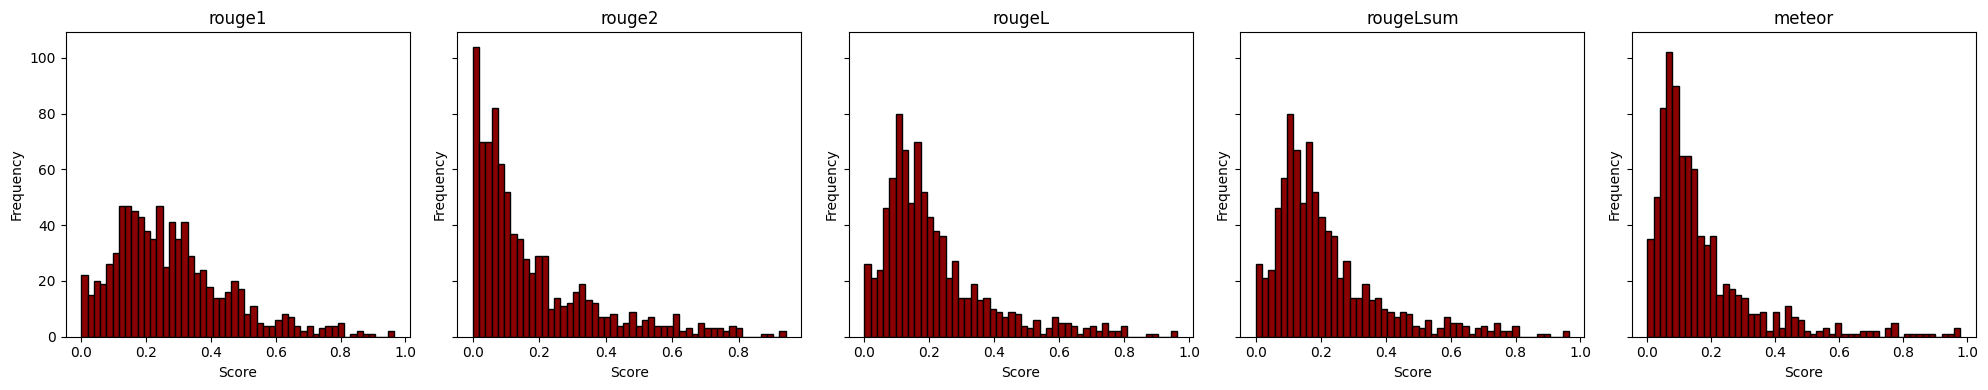

In [ ]:
import matplotlib.pyplot as plt

# to get the image you want, then make sure df is defined as what you want to see

model_evaluation = 't5_baseline_level_2_150_evaluation'

plot_path = root_evaluation_path + model_evaluation + '.csv'

df = pd.read_csv(plot_path)
# df['ModelEvalation'] = model_evaluation
df = df.drop(columns=['GeneratedText', 'ReferenceText'])

fig, axs = plt.subplots(1, 8, figsize=(20, 4), sharey=True)

for i, col in enumerate(df.columns):
    axs[i].hist(df[col], bins=50, color='darkred', edgecolor='black')  # Adjust bins as needed
    axs[i].set_title(col)
    axs[i].set_xlabel('Score')
    axs[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()
